In [1]:
from __future__ import print_function

import sys
import os

#sys.path.append('UrbanCNN/');
#sys.path.append('srimmele/');
#sys.path.append('ecbm4040/');

from matplotlib.pyplot import imshow, plot, title, subplots


from srimmele.data_utils import getCityImages
from UrbanCNN.utils import generator_from_file
import numpy as np

# these magics ensure that external modules that are modified are also automatically reloaded
%load_ext autoreload
%autoreload 2
%matplotlib inline


In [2]:
city = 'berlin, de'
if not os.path.exists('imagery/' + city):
    getCityImages(city)
else:
    print ('Image files already extracted')

Image files already extracted


[Image augmentation in original paper](https://github.com/adrianalbert/urban-environments/blob/master/land-use-classification/Finetuning%20on%20Urban%20Atlas%20data.ipynb)

In [3]:
all_classes = '''Agricultural + Semi-natural areas + Wetlands
Airports
Construction sites
Continuous Urban Fabric (S.L. > 80%)
Discontinuous Dense Urban Fabric (S.L. : 50% -  80%)
Discontinuous Low Density Urban Fabric (S.L. : 10% - 30%)
Discontinuous Medium Density Urban Fabric (S.L. : 30% - 50%)
Discontinuous Very Low Density Urban Fabric (S.L. < 10%)
Fast transit roads and associated land
Forests
Green urban areas
Industrial, commercial, public, military and private units
Isolated Structures
Land without current use
Mineral extraction and dump sites
Other roads and associated land
Port areas
Railways and associated land
Sports and leisure facilities
Water bodies'''.split("\n")

classes = all_classes
print(len(classes))

class2label = {c:i for i,c in enumerate(classes)}
label2class = {i:c for i,c in enumerate(classes)}
class_weights = {c:1 for c in label2class.keys()}

20


In [4]:
from keras.preprocessing.image import ImageDataGenerator


#this is the augmentation configuration the author's use for training
train_augmenter = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.10,
        zoom_range=[1,1.2],
        vertical_flip=True,
        rotation_range=15,
        horizontal_flip=True)

test_augmenter = ImageDataGenerator(rescale=1./255)

Using TensorFlow backend.


In [4]:
train_generator     = generator_from_file('data/train.csv', image_generator= None, balance=1, \
                            batch_size = 50, seed=26, new_img_shape= (224,224), \
                            class_dict=None, shuffle=True, channels="RGB",
                            downsample=True, crop= None, batch_type = None, one_hot = False)
# validation was 112 for successful runs
validation_generator = generator_from_file('data/test.csv', image_generator= None, balance=1, \
                        batch_size = 100, seed=26, new_img_shape= (224,224), \
                        class_dict=None, shuffle=True, channels="RGB",
                        downsample=False, crop = None, batch_type = None, one_hot = False)


/home/ecbm4040/miniconda2/envs/dlenv/lib/python3.5/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


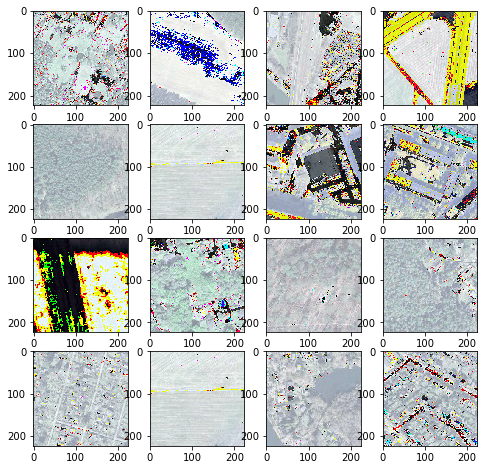

In [5]:
from numpy import random

r = 4
f, axarr = subplots(r, r, figsize=(8,8))
test = next(train_generator)

for i in range(r):
    for j in range(r):

        img = test[0][random.randint(0,50),:,:,:] 
        axarr[i][j].imshow(img)
        #title(label2class[test[1][0]])


/home/ecbm4040/miniconda2/envs/dlenv/lib/python3.5/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


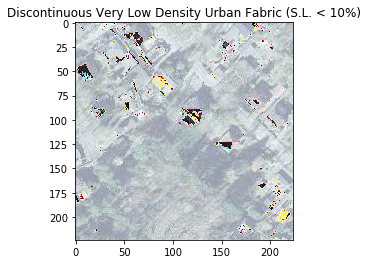

In [56]:
## construction sites are largely inaccurate

test = next(train_generator)
image =imshow(test[0][0,:,:,:])
test[1][0]
title(label2class[test[1][0]])


/home/ecbm4040/miniconda2/envs/dlenv/lib/python3.5/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


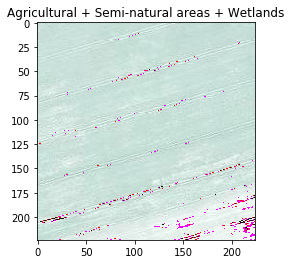

In [6]:
test = next(validation_generator)
image =imshow(test[0][1,:,:,:])
title(label2class[test[1][1]])


In [9]:
conv_feat_dict = {}

conv_feat_dict[0] = [64 , 64]
conv_feat_dict[1] = [128 , 128]
conv_feat_dict[2] = [256 ,256, 256]
conv_feat_dict[3] = [512 , 512, 512]
conv_feat_dict[4] = [512 , 512, 512]

conv_kernel_dict = dict(keys = conv_feat_dict.keys())

conv_kernel_dict[0] = [2] * 2
conv_kernel_dict[1] = [2] * 2
conv_kernel_dict[2] = [2] * 3
conv_kernel_dict[3] = [2] * 3
conv_kernel_dict[4] = [2] * 3

pooling_size_dict = dict(keys = conv_feat_dict.keys())

pooling_size_dict[0] = [2] * 2
pooling_size_dict[1] = [2] * 2
pooling_size_dict[2] = [2] * 3
pooling_size_dict[3] = [2] * 3 
pooling_size_dict[4] = [2] * 3

fc_units = [4096, 4096]


In [ ]:
import tensorflow as tf
from srimmele.classifiers import training

tf.reset_default_graph()

training(train_generator, validation_generator,
             conv_feat_dict = conv_feat_dict,
             fc_units = fc_units,
             conv_kernel_dict = conv_kernel_dict,
             pooling_size_dict = pooling_size_dict,
             img_size = 224,
             l2_norm=0.0,
             seed=422,
             batch_size = 50,
             learning_rate= 0.1,
             lr_decay = 2.0,
             epoch=40,
             samples_per_epoch = 2000,
             verbose=False,
             pre_trained_model=None)

epoch 1 


/home/ecbm4040/miniconda2/envs/dlenv/lib/python3.5/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


Best validation accuracy! iteration:10 accuracy: 14.0%
Best validation accuracy! iteration:30 accuracy: 20.0%
epoch 2 


VGG16_1513200379
VGG16_1513200871 

Share with TAs : VGG16_1513203220

## Best: VGG16_1513216839, 90% val
* batch size 50
* 40 epochs
* kernel size 2

## Best: VGG16_1513212753 , 64% val
* batch size 50
* 50 epochs
* kernel size 1